In [2]:
from __future__ import annotations
try:
    from mediocreatbest import auto, run
except ImportError:
    %pip install --user --upgrade pip
    %pip install --user --upgrade --force-reinstall \
        git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df#egg=mediocreatbest[jupyter]
    from mediocreatbest import auto, run


## Sanity Check

In [3]:
!docker system info \
    --format '{{{{ json .Runtimes }}}}' \
| jq . \
##

{
  "io.containerd.runc.v2": {
    "path": "runc"
  },
  "nvidia": {
    "path": "nvidia-container-runtime"
  },
  "runc": {
    "path": "runc"
  }
}


In [7]:
!nvidia-smi

Thu Aug 10 16:26:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M6000 24GB   Off  | 00000000:82:00.0 Off |                  Off |
| 21%   36C    P0    60W / 250W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!docker run \
    --rm \
    --runtime=nvidia \
    hello-world \
##


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



## Configure, Build, and Install

In [9]:
!./go.sh docker stop \
|| true

Error response from daemon: No such container: graphshaders


In [10]:
!./go.sh docker build \
##

[+] Building 0.0s (0/1)                                                         
[+] Building 0.2s (2/3)                                                         
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 292B                                          0.0s
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.69kB                                     0.0s
 => [internal] load metadata for docker.io/nvidia/opengl:1.2-glvnd-runtim  0.1s
[+] Building 0.3s (2/3)                                                         
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 292B                                          0.0s
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.69kB                                     0.0s
 => [internal] load metadata for dock

In [11]:
!./go.sh docker start \
##

70ba419083be90af44174629e64fed8f7600132b7dc99e57eed44f965a33a3a5


In [12]:
!./go.sh docker exec ./go.sh gs configure \
##

-- Configuring done
-- Generating done
-- Build files have been written to: /home/thobson2/src/GraphShaders/build
-- Cache values
CMAKE_BUILD_TYPE:STRING=Debug
CMAKE_INSTALL_PREFIX:PATH=/home/thobson2/src/GraphShaders/stage


In [13]:
!./go.sh docker exec ./go.sh gs build \
##

/usr/bin/cmake -S/home/thobson2/src/GraphShaders -B/home/thobson2/src/GraphShaders/build --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/cmake -E cmake_progress_start /home/thobson2/src/GraphShaders/build/CMakeFiles /home/thobson2/src/GraphShaders/build/CMakeFiles/progress.marks
/usr/bin/make -f CMakeFiles/Makefile2 all
make[1]: Entering directory '/home/thobson2/src/GraphShaders/build'
/usr/bin/make -f CMakeFiles/GraphShaderEngine.dir/build.make CMakeFiles/GraphShaderEngine.dir/depend
make[2]: Entering directory '/home/thobson2/src/GraphShaders/build'
cd /home/thobson2/src/GraphShaders/build && /usr/bin/cmake -E cmake_depends "Unix Makefiles" /home/thobson2/src/GraphShaders /home/thobson2/src/GraphShaders /home/thobson2/src/GraphShaders/build /home/thobson2/src/GraphShaders/build /home/thobson2/src/GraphShaders/build/CMakeFiles/GraphShaderEngine.dir/DependInfo.cmake --color=
make[2]: Leaving directory '/home/thobson2/src/GraphShaders/build'
/usr/bin/make -f CMakeFiles/GraphS

In [14]:
!./go.sh docker exec ./go.sh gs install \
##

-- Install configuration: "Debug"
-- Up-to-date: /home/thobson2/src/GraphShaders/stage/bin/GraphShaderEngine
-- Up-to-date: /home/thobson2/src/GraphShaders/stage/bin/GraphShaderTranspiler.py


## Utility (gs magic)

In [19]:
@auto.IPython.core.magic.register_cell_magic
def gs(line: str, cell: str, *, temp=auto.pathlib.Path('tmp')):
    while line.endswith('\\'):
        line = line.removesuffix('\\')
        l, r = cell.split('\n', 1)
        line += l
        cell = r
        
    def gs(args: list[str]):
        inpfile = temp / 'inpfile.gsp'
        outfile = temp / 'outfile.jpg'
        
        inpfile.write_text(cell)
        
        args = [
            './go.sh', 'docker', 'exec',
            './go.sh', 'gs', 'exec',
            'GraphShaderTranspiler.py',
            *args,
            '-i', str(inpfile),
            '-e', 'GS_OUTPUT', str(outfile),
        ]
        
        print(f'$ {auto.shlex.join(args)}', file=auto.sys.stderr, flush=True)
        auto.subprocess.check_call(args)
        
        auto.IPython.display.clear_output(wait=True)
        auto.IPython.display.display(auto.IPython.display.Image(outfile))
    
    args = auto.shlex.split(line)
#     parser = auto.argparse.ArgumentParser(prog='%%gs')
#     args = vars(parser.parse_args(  ))
    
    gs(args)

del gs

## Example: JS-Deps

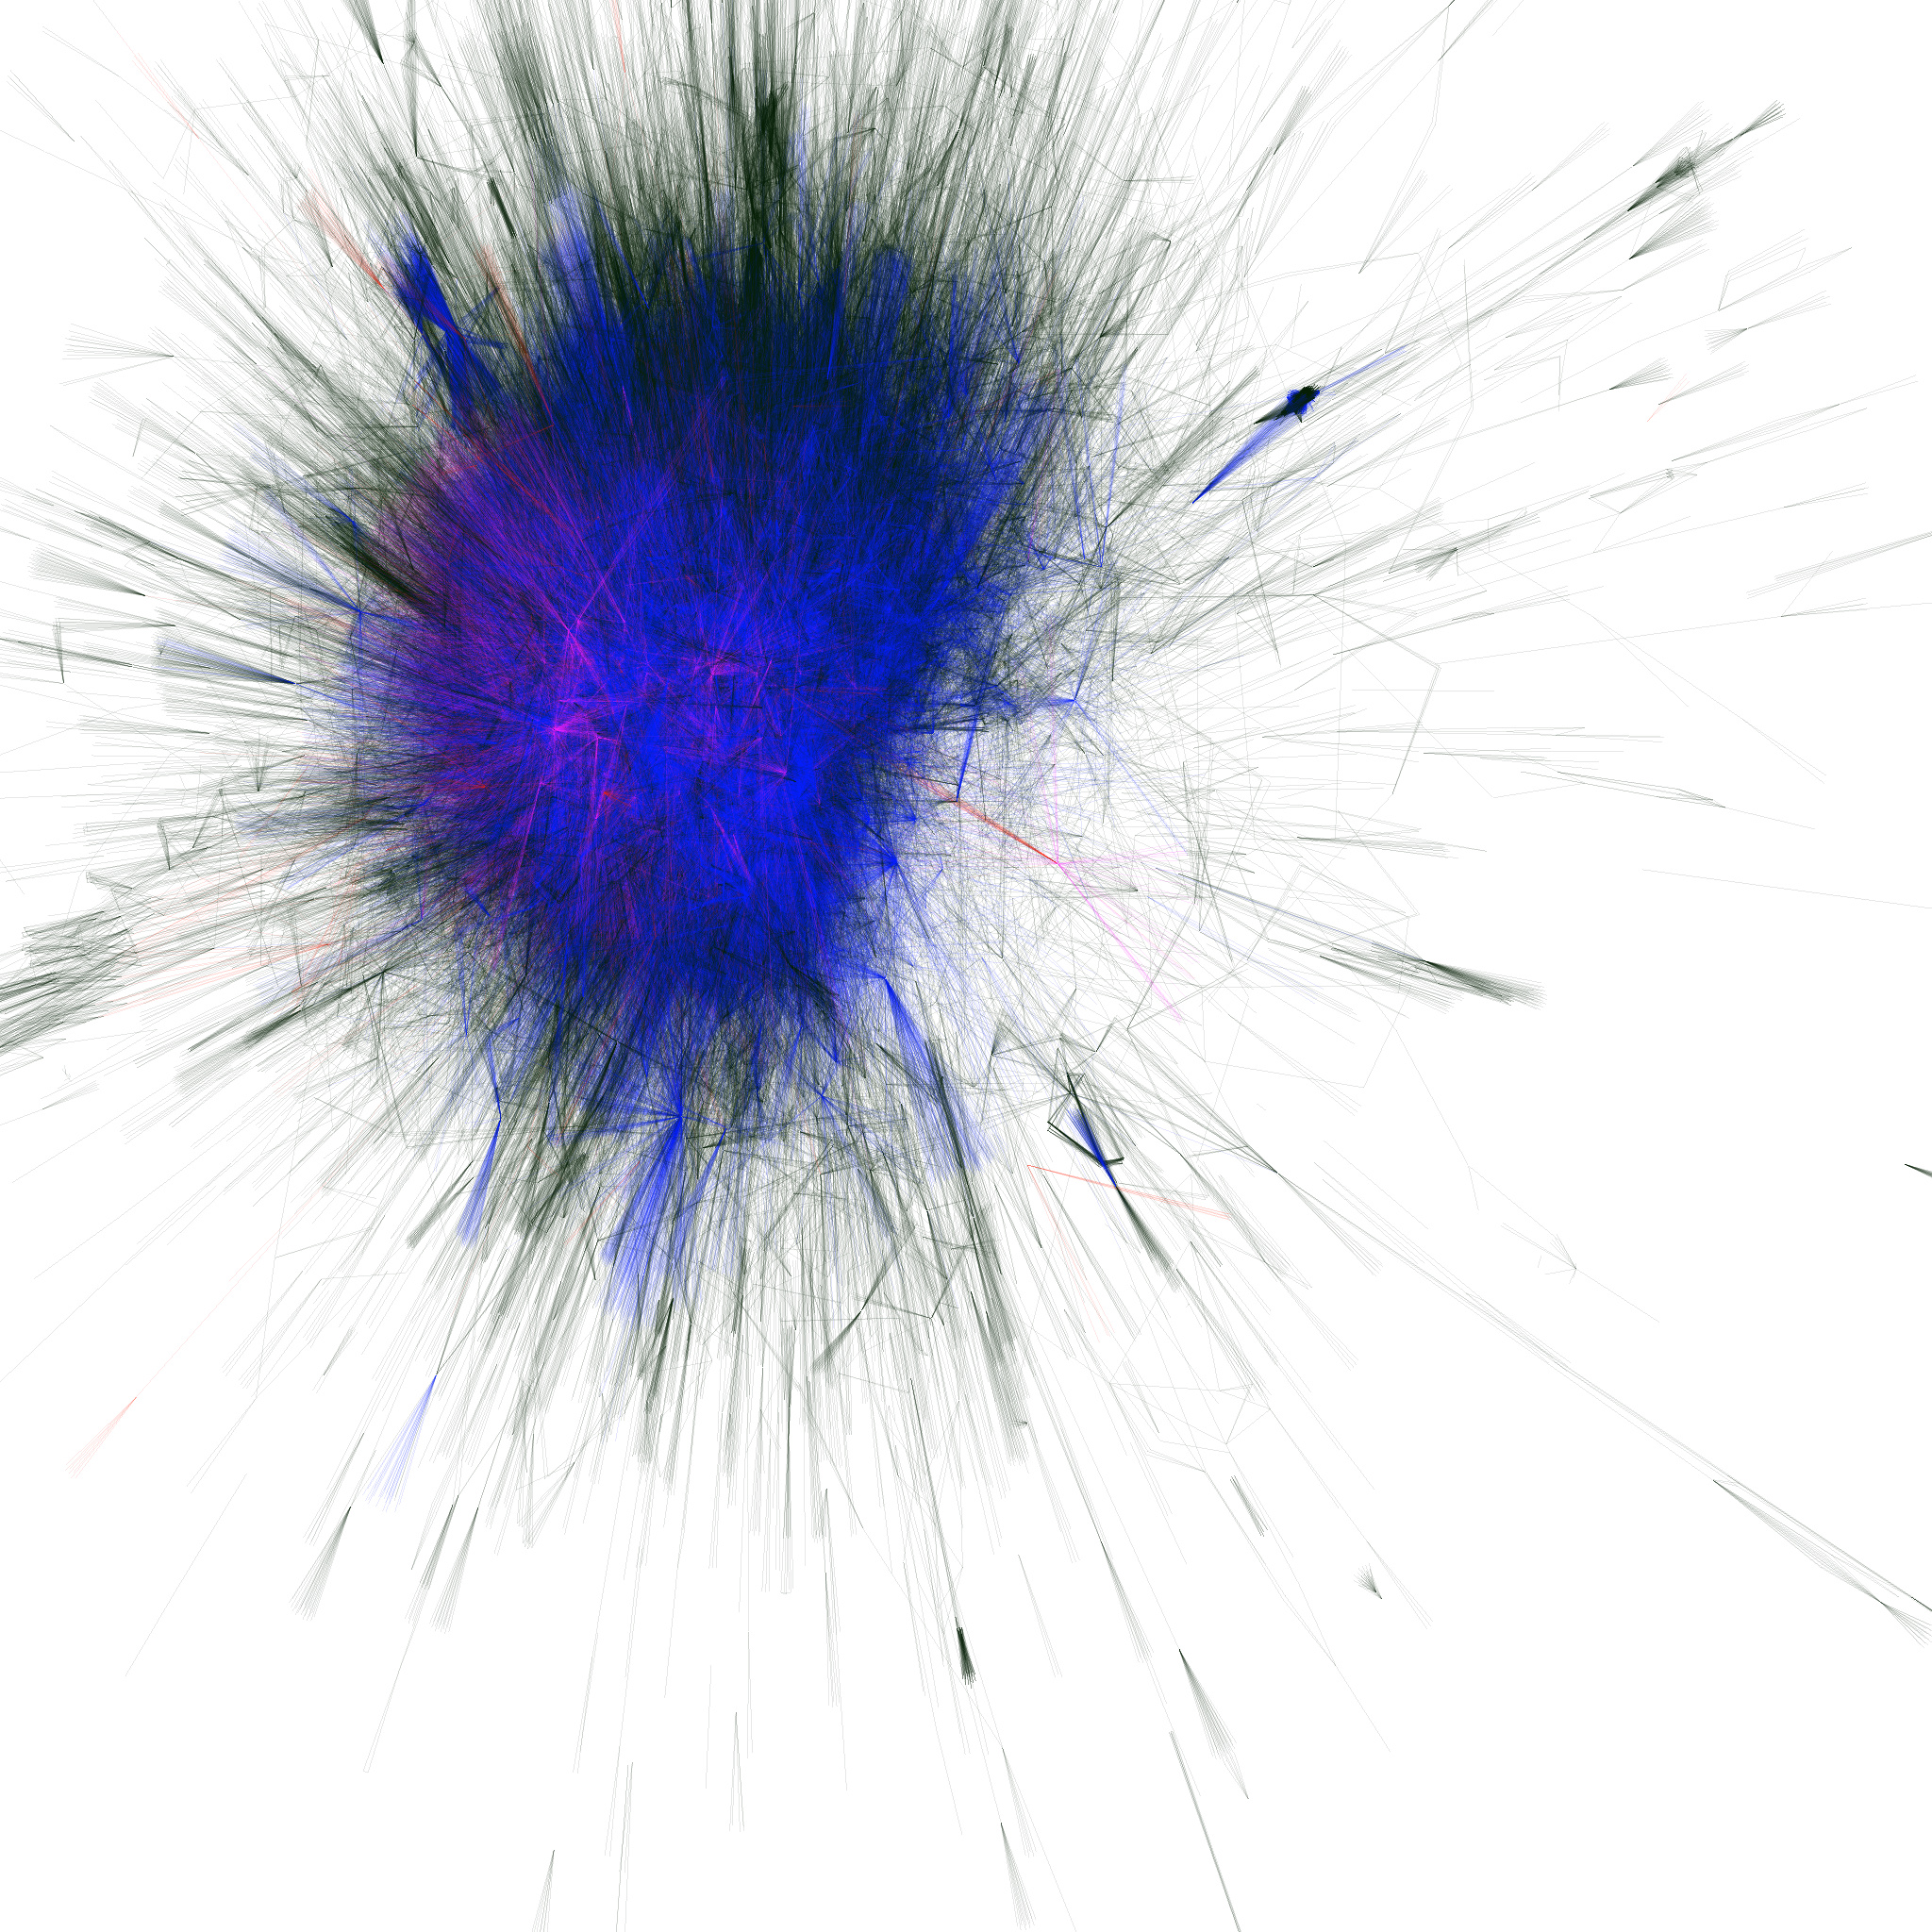

In [20]:
%%gs \
    -f element "examples/JS-Deps/data/JS-Deps.edge.elements.2u32.bin" \
    -f X       "examples/JS-Deps/data/JS-Deps.node.x.f32.bin" \
    -f Y       "examples/JS-Deps/data/JS-Deps.node.y.f32.bin" \
    -f Date    "examples/JS-Deps/data/JS-Deps.node.date.u32.bin" \
    -f Devs    "examples/JS-Deps/data/JS-Deps.node.nmaintainers.u32.bin" \
    -f Vuln    "examples/JS-Deps/data/JS-Deps.node.cve.u32.bin" \
    -e GS_TILE_WIDTH  2048 \
    -e GS_TILE_HEIGHT 2048 \
    -e GS_TILE_Z 1 \
    -e GS_TILE_X 0.5 \
    -e GS_TILE_Y 0.5

// JS-Deps: Node Package Manager Dependency Graph
//
// Nodes are packages. Edges are directed from a package to its dependencies.

#pragma gs attribute(float X[N])
#pragma gs attribute(float Y[N])
#pragma gs attribute(uint Date[N])
#pragma gs attribute(uint Devs[N])
#pragma gs attribute(uint Vuln[N])

#define NOV_09_2010 1289278800
#define MAR_22_2016 1458619200

#define JAN_01_2011 1293858000
#define JAN_01_2012 1325394000
#define JAN_01_2013 1357016400
#define JAN_01_2014 1388552400
#define JAN_01_2015 1420088400
#define JAN_01_2016 1451624400

// Some controls
#pragma gs define(USE_COLOR)
#pragma gs define(USE_FILTER)
#pragma gs define(USE_RELATIONAL)


#pragma gs shader(positional)
void main() {
    float x = X[gs_NodeIndex];
    float y = Y[gs_NodeIndex];

    gs_NodePosition = vec3(x, y, 0);
}


#pragma gs shader(relational)
void main() {
    #pragma gs scratch(uint in_degree[N])
    #pragma gs scratch(uint out_degree[N])
    #pragma gs scratch(atomic_uint in_degree_max)
    #pragma gs scratch(atomic_uint out_degree_max)

    #pragma gs define(USE_RELATIONAL 1)
    #if USE_RELATIONAL
    uint od = 1 + atomicAdd(out_degree[gs_SourceIndex], 1);
    atomicCounterMax(out_degree_max, od);

    uint id = 1 + atomicAdd(in_degree[gs_TargetIndex], 1);
    atomicCounterMax(in_degree_max, id);
    #endif /* USE_RELATIONAL */
}


#pragma gs shader(appearance)
void main() {
    #pragma gs scratch(uint Seen[E])
    bool first = 0 == atomicAdd(Seen[gs_EdgeIndex], 1);
    bool d = false;

    #pragma gs scratch(atomic_uint total)
    if (first) atomicCounterAdd(total, 1);

    #pragma gs define(FILTER_BY_DATE 1)
    #if FILTER_BY_DATE
    #pragma gs define(LO JAN_01_2014)
    #pragma gs define(HI JAN_01_2015)

    if (Date[gs_SourceIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_lo)
        if (first) atomicCounterAdd(source_date_too_lo, 1);
    }

    if (Date[gs_SourceIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint source_date_too_hi)
        if (first) atomicCounterAdd(source_date_too_hi, 1);
    }

    if (Date[gs_TargetIndex] < LO) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_lo)
        if (first) atomicCounterAdd(target_date_too_lo, 1);
    }

    if (Date[gs_TargetIndex] > HI) {
        d = true;
        #pragma gs scratch(atomic_uint target_date_too_hi)
        if (first) atomicCounterAdd(target_date_too_hi, 1);
    }
    #endif /* FILTER_BY_DATE */

    if (d) {
        #pragma gs scratch(atomic_uint discarded)
        if (first) atomicCounterAdd(discarded, 1);
        discard;
    } else {
        #pragma gs scratch(atomic_uint kept)
        if (first) atomicCounterAdd(kept, 1);
    }

    bool vuln = bool(Vuln[gs_SourceIndex]) || bool(Vuln[gs_TargetIndex]);
    bool risky = Devs[gs_SourceIndex] > Devs[gs_TargetIndex];

    #if USE_RELATIONAL
    const uint depends_on_source = in_degree[gs_SourceIndex];
    const uint depends_on_target = in_degree[gs_TargetIndex];

    risky = depends_on_source + depends_on_target > 100 * Devs[gs_TargetIndex];
    #endif /* USE_RELATIONAL */

    if (risky) {
        #pragma gs scratch(atomic_uint total_risky)
        if (first) atomicCounterAdd(total_risky, 1);
    }

    if (risky && vuln) {
        #pragma gs scratch(atomic_uint total_vuln_and_risky)
        if (first) atomicCounterAdd(total_vuln_and_risky, 1);
    }

    if (vuln) {
        #pragma gs scratch(atomic_uint total_vuln)
        if (first) atomicCounterAdd(total_vuln, 1);
    }

    gs_FragColor = vec4(0.1);
    gs_FragColor.r = float(vuln);
    gs_FragColor.b = float(risky);
}

